# DM-35922 : document where the wavefront is calculated in `ts_wep` 

Author: Chris Suberlak (@suberlak)

Last Verified to Run: 2022-08-18

Software Versions:

* ts_wep: **v2.5.4**
* lsst_distrib: **w_2022_32**

We know that `ts_ofc`  expects as part of the loop already a sensor-averaged  wavefront error estimate (called in butler outputZernikesAvg  https://github.com/lsst-ts/ts_phosim/blob/2a06807d495eb21e38aac196b0c88d6842de0f72/python/lsst/ts/phosim/CloseLoopTask.py#L660). Indeed, immediately  `ts_ofc` checks if there is exactly as many wavefront error arrays as field indices https://github.com/lsst-ts/ts_ofc/blob/761a71adde8ee75353ec6d9fed06dd9dd5ce79af/python/lsst/ts/ofc/ofc.py#L146  . But a step earlier in `ts_wep`, before averaging, we calculate `outputZernikesRaw`  in https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L511 which comes directly from `Algorithm.py`  https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L785 . 

Thus here we explore parts of `Algorithm.py`, to find out what happens at each stage. We use a recent simulation of corner sensor images with one star per sensor. 

--> use data from DM-35919_example_wfs_star
--> read in as donut stamps (skipping all other parts of ts_wep) just like in AOS_DM-33104_masks_centroid

--> take algorithm.py apart, highlighting all the steps...

In [14]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

In [2]:


def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog


In [17]:
repo_dir  = 'DM-35919_phosim_example/example_wfs/phosimData'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

In [9]:
def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0,
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId,
                          collections=[collection])
    return postIsr

In [11]:
sensor='R04'
extraImage = get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

Run the baseline fit inside the `EstimateZernikesBase`:

In [12]:
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

In [15]:
# now instead of calling
# wfEsti = WfEstimator(instDir, algoDir)
# I dig inside it

# this is part of the init
inst = Instrument(instDir)
algo = Algorithm(algoDir)

#imgIntra = CompensableImage()
#imgExtra = CompensableImage()

#opticalModel = ""
#sizeInPix = 0

# now get the camera type and defocal distance
# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
# https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L134
instName='lsst'
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)


In [27]:
#
# now instead of calling
# wfEsti.config( sizeInPix=self.donutStampSize, camType=camType,
#                opticalModel=self.opticalModel, defocalDisInMm=defocalDisInMm,
# )

# I update the parameters
opticalModel = 'offAxis'
# Update the instrument name
#donutStampSize = 160 # px
#sizeInPix = donutStampSize
sizeInPix = 160# int(sizeInPix)

inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel=0 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

# select the only donut pair in that corner
i=0
donutExtra = donutStampsExtra[i]
donutIntra = donutStampsIntra[i]

print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')
fieldXYExtra = donutExtra.calcFieldXY()
fieldXYIntra = donutIntra.calcFieldXY()

camera = donutExtra.getCamera() # same camera for both donuts
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)


# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

# Now instead of running `wfEsti.setImg` method, do it by hand, since
# it inherits 'setImg' from 'CompensableImage' anyway...


#####################################
# Step 2 : baseline fit (no offset)
#####################################
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

boundaryT = algo.getBoundaryThickness()

# right after we set the image, the compensable image mask is empty -
# it is only calculated in algo
# https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
maskScalingFactorLocal = 1
#imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
#imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)


# now wfEsti.reset() simply calls the same method in `Algorithm.py` :
#algo.reset()

# now wfEsti.calWfsErr() after checking for image size (both need to be squares)
# simply calls algo:
#tol = 1e-3 # explicitly set the tolerance level ( this is default )
#algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
#zk_no_offset = algo.getZer4UpInNm()


 Fitting sensor R04, donutIntra 0, donutExtra 0 


In [19]:
zk_no_offset

array([-7.34662242e+02,  9.94728148e+02,  6.47895069e+02,  4.69427303e+01,
       -1.13483646e+02,  1.87000221e+02,  1.08098872e+02, -3.30296073e+01,
       -2.63344351e+01, -4.42576922e+01,  9.01585760e+01,  2.63663232e+01,
       -3.17118958e+00,  3.45819751e+00, -3.89959514e+01, -5.45600481e+00,
       -8.63745961e-01, -5.78678540e+00, -7.83567788e+00])

In [28]:
I1 = imgIntra
I2 = imgExtra
model = opticalModel
tol=1e-3

Dig inside `Algorithm.py`. We call `runIt` method which contains

    def runIt(self, I1, I2, model, tol=1e-3):
        
        # To have the iteration time initiated from global variable is to
        # distinguish the manually and automatically iteration processes.
        itr = self.currentItr
        while itr <= self.getNumOfOuterItr():
            stopItr = self._singleItr(I1, I2, model, tol)

            # Stop the iteration of outer loop if converged
            if stopItr:
                break

            itr += 1

In [20]:
algo.reset()

In [22]:
itr = algo.currentItr
print(itr)

0


Then a `_singleItr` is  called, which contains

    def _singleItr(self, I1, I2, model, tol=1e-3):

In [29]:
# initially the compensable image has not been calculated 
I1.getImgInit()

In [30]:
model

'offAxis'

In [31]:
# Use the zonal mode ("zer")
compMode = algo.getCompensatorMode()

# Define the gain of feedbackGain
feedbackGain = algo.getFeedbackGain()

# Set the pre-condition
if algo.currentItr == 0:

    # Check this is the first time of running iteration or not
    if I1.getImgInit() is None or I2.getImgInit() is None:

        # Check the image dimension
        if I1.getImg().shape != I2.getImg().shape:
            print(
                "Error: The intra and extra image stamps need to be of same size."
            )
          

        # Calculate the pupil mask (binary matrix) and related
        # parameters
        boundaryT = algo.getBoundaryThickness()
        I1.makeMask(algo._inst, model, boundaryT, 1)
        I2.makeMask(algo._inst, model, boundaryT, 1)
        algo._makeMasterMask(I1, I2, algo.getPoissonSolverName())

        # Load the offAxis correction coefficients
        if model == "offAxis":
            offAxisPolyOrder = algo.getOffAxisPolyOrder()
            I1.setOffAxisCorr(algo._inst, offAxisPolyOrder)
            I2.setOffAxisCorr(algo._inst, offAxisPolyOrder)

        # Cocenter the images to the center referenced to fieldX and
        # fieldY. Need to check the availability of this.
        I1.imageCoCenter(algo._inst, debugLevel=algo.debugLevel)
        I2.imageCoCenter(algo._inst, debugLevel=algo.debugLevel)

        # Update the self-initial image
        I1.updateImgInit()
        I2.updateImgInit()

    # Initialize the variables used in the iteration.
    algo.zcomp = np.zeros(algo.getNumOfZernikes())
    algo.zc = algo.zcomp.copy()

    dimOfDonut = algo._inst.getDimOfDonutOnSensor()
    algo.wcomp = np.zeros((dimOfDonut, dimOfDonut))
    algo.West = algo.wcomp.copy()

    algo.caustic = False

# Rename this index (currentItr) for the simplification
jj = algo.currentItr


In [32]:
I1

In [34]:
algo.zcomp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [37]:
# Solve the transport of intensity equation (TIE)
if not algo.caustic:

    # Reset the images before the compensation
    I1.updateImage(I1.getImgInit().copy())
    I2.updateImage(I2.getImgInit().copy())

    if compMode == "zer":

        # Zk coefficient from the previous iteration
        ztmp = algo.zc.copy()

        # Do the feedback of Zk from the lower terms first based on the
        # sequence defined in compSequence
        if jj != 0:
            compSequence = algo.getCompSequence()
            ztmp[int(compSequence[jj - 1]) :] = 0
        print(ztmp)
        print(feedbackGain)
        # Add partial feedback of residual estimated wavefront in Zk
        algo.zcomp = algo.zcomp + ztmp * feedbackGain

        # Remove the image distortion by forwarding the image to pupil
        I1.compensate(algo._inst, algo, algo.zcomp, model)
        I2.compensate(algo._inst, algo, algo.zcomp, model)

    # Check the image condition. If there is the problem, done with
    # this _singleItr().
    if (I1.isCaustic() is True) or (I2.isCaustic() is True):
        algo.converge[:, jj] = algo.converge[:, jj - 1]
        algo.caustic = True
        #return

    # Correct the defocal images if I1 and I2 are belong to different
    # sources, which is determined by the (fieldX, field Y)
    I1, I2 = algo._applyI1I2mask_pupil(I1, I2)

    

   

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.6


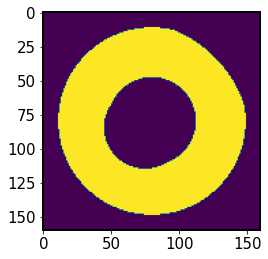

In [40]:
plt.imshow(I1.getPaddedMask())

In [41]:
algo.caustic

False

In [ ]:
# this is continued under the assumption that 
# caustic has not yet been reached 

# if not algo.caustic:
#     # Solve the Poisson's equation
#     algo.zc, algo.West = algo._solvePoissonEq(I1, I2, jj)

Inside `def _solvePoissonEq(self, I1, I2, iOutItr=0): : `

In [43]:
# Calculate the aperture pixel size
apertureDiameter = algo._inst.getApertureDiameter()
sensorFactor = algo._inst.getSensorFactor()
dimOfDonut = algo._inst.getDimOfDonutOnSensor()
aperturePixelSize = apertureDiameter * sensorFactor / dimOfDonut

# Calculate the differential Omega
dOmega = aperturePixelSize**2

# Solve the Poisson's equation based on the type of algorithm
numTerms = algo.getNumOfZernikes()
zobsR = algo.getObsOfZernikes()
PoissonSolver = algo.getPoissonSolverName()
print(PoissonSolver)

exp


In [44]:
# elif PoissonSolver == "exp":

# Use the integration method by serial expansion to solve the
# Poisson's equation

# Calculate I0 and dI
I0, dI = algo._getdIandI(I1, I2)

# Get the x, y coordinate in mask. The element outside mask is 0.
xSensor, ySensor = algo._inst.getSensorCoor()
xSensor = xSensor * algo.mask_comp
ySensor = ySensor * algo.mask_comp

# Create the F matrix and Zernike-related matrixes

# Get Zernike and gradient bases from cache.  These are each
# (nzk, npix, npix) arrays, with the first dimension indicating
# the Noll index.
zk, dzkdx, dzkdy = algo._zernikeBasisCache()

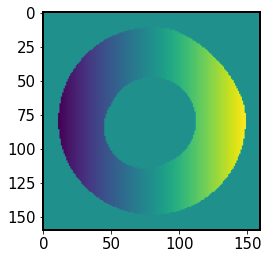

In [48]:
plt.imshow(xSensor)

In [49]:
# Eqn. (19) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
# F_j = \int (d_z I) Z_j d_Omega
F = np.tensordot(dI, zk, axes=((0, 1), (1, 2))) * dOmega
# Eqn. (20) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
# M_ij = \int I (grad Z_j) . (grad Z_i) d_Omega
#      =   \int I (dZ_i/dx) (dZ_j/dx) d_Omega
#        + \int I (dZ_i/dy) (dZ_j/dy) d_Omega
Mij = np.einsum("ab,iab,jab->ij", I0, dzkdx, dzkdx)
Mij += np.einsum("ab,iab,jab->ij", I0, dzkdy, dzkdy)
Mij *= dOmega / (apertureDiameter / 2.0) ** 2

# Calculate dz
focalLength = algo._inst.getFocalLength()
offset = algo._inst.getDefocalDisOffset()
dz = 2 * focalLength * (focalLength - offset) / offset

# Define zc
zc = np.zeros(numTerms)

# Consider specific Zk terms only
idx = algo.getZernikeTerms()

In [50]:
Mij

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  7.88542225e-04,  0.00000000e+00,
         4.91977091e-05,  4.02597038e-06,  1.77726261e-05,
         3.09967619e-04,  2.76494362e-03,  2.15467014e-04,
         4.11091012e-05, -8.92718953e-04, -2.19718404e-04,
         2.83716389e-04, -5.53507325e-06,  2.67099693e-05,
        -3.59526828e-04,  1.96987423e-04,  8.39585441e-06,
         3.22614938e-04, -3.20964610e-05,  2.76141752e-05,
        -6.73067634e-04],
       [ 0.00000000e+00,  0.00000000e+00,  7.88542225e-04,
         1.11445838e-05,  1.77726261e-05, -4.02597038e-06,
    

In [52]:
from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularEval,
    ZernikeMaskedFit,
)
# Solve the equation: M*W = F => W = M^(-1)*F
zc_tmp = np.linalg.lstsq(Mij[:, idx][idx], F[idx], rcond=None)[0] / dz
zc[idx] = zc_tmp

# Estimate the wavefront surface based on z4 - z22
# z0 - z3 are set to be 0 instead
West = ZernikeAnnularEval(
    np.concatenate(([0, 0, 0], zc[3:])), xSensor, ySensor, zobsR
)

In [54]:
zc

array([ 0.00000000e+00, -7.89738924e-07,  3.16099878e-06, -4.21900273e-07,
        6.38963879e-07,  5.92138899e-07, -1.00960004e-07, -9.06251879e-08,
       -2.76126339e-09,  4.93546657e-09,  7.63387345e-09, -4.22784396e-08,
       -5.90015864e-08, -2.83604261e-08,  3.83649584e-08,  3.17085265e-08,
       -1.32086350e-08, -2.67198724e-08, -1.20163994e-09, -6.85416690e-09,
        7.89020215e-10,  1.92269035e-08])

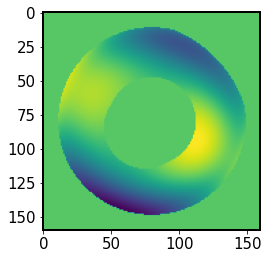

In [53]:
plt.imshow(West)

In [ ]:
 # Record/ calculate the Zk coefficient and wavefront
    if compMode == "zer":
        algo.converge[:, jj] = algo.zcomp +algo.zc

        xoSensor, yoSensor = algo._inst.getSensorCoorAnnular()
        algo.wcomp = algo.West + ZernikeAnnularEval(
            np.concatenate(([0, 0, 0], algo.zcomp[3:])),
            xoSensor,
            yoSensor,
            algo.getObsOfZernikes(),
        )

else:
    # Once we run into caustic, stop here, results may be close to real
    # aberration.
    # Continuation may lead to disastrous results.
    algo.converge[:, jj] = algo.converge[:, jj - 1]

# Record the coefficients of normal/ annular Zernike polynomials after
# z4 in unit of nm
algo.zer4UpNm = algo.converge[3:, jj] * 1e9

# Status of iteration
stopItr = False

# Calculate the difference
if jj > 0:
    diffZk = (
        np.sum(np.abs(algo.converge[:, jj] - algo.converge[:, jj - 1])) * 1e9
    )

    # Check the Status of iteration
    if diffZk < tol:
        stopItr = True

# Update the current iteration time
algo.currentItr += 1

# Show the Zk coefficients in interger in each iteration
if algo.debugLevel >= 2:
    print("itr = %d, z4-z%d" % (jj, algo.getNumOfZernikes()))
    print(np.rint(algo.zer4UpNm))
